In [1]:
import os
import glob

from Offline import utils
from sklearn.metrics import roc_curve, auc, roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, signal
from scipy.stats import ttest_ind
from scipy.interpolate import interp1d
import mne
from mne.stats import permutation_cluster_test
from mne.evoked import _get_peak
import pandas as pd
import seaborn as sns

np.random.seed(0)
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(style="white")

In [2]:
# load tmp data
data_dir = './data/epoch_data'
f_list = glob.glob(os.path.join(data_dir, '*.npz'))
print(f_list)
data_list = [np.load(f) for f in f_list]
t_ori = (-0.3, 0.6)
t_tar = (0, 0.5)

['./data/epoch_data\\S10_epochs.npz', './data/epoch_data\\S1_epochs.npz', './data/epoch_data\\S2_epochs.npz', './data/epoch_data\\S3_epochs.npz', './data/epoch_data\\S4_epochs.npz', './data/epoch_data\\S5_epochs.npz', './data/epoch_data\\S6_epochs.npz', './data/epoch_data\\S7_epochs.npz', './data/epoch_data\\S8_epochs.npz', './data/epoch_data\\S9_epochs.npz']


## Temporal pattern

In [3]:
epochs = np.concatenate([d['epochs'] for d in data_list], axis=0)
y = np.concatenate([d['y'] for d in data_list], axis=0)
print(epochs.shape)
print(y.shape)

(7200, 8, 900)
(7200,)


In [4]:
# clustering test
T = []
clu = []
p_clu = []
for i in range(epochs.shape[1]):
    x_l = epochs[y == 1, i]
    x_r = epochs[y == 2, i]
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)
    T.append(T_obs)
    clu.append(clusters)
    p_clu.append(cluster_p_values)

Using a threshold of 3.845340
stat_fun(H1): min=0.000021 max=39.903261
Running initial clustering
Found 3 clusters
Permuting 999 times...
[                                                            ]   0.00%  |   

<ipython-input-4-d910b023e986>:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)



Computing cluster p-values
Done.
Using a threshold of 3.845340
stat_fun(H1): min=0.000005 max=210.356582
Running initial clustering
Found 5 clusters
Permuting 999 times...
[                                                            ]   0.00%  |   

<ipython-input-4-d910b023e986>:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)



Computing cluster p-values
Done.
Using a threshold of 3.845340
stat_fun(H1): min=0.000002 max=108.382114
Running initial clustering
Found 5 clusters
Permuting 999 times...
[                                                            ]   0.00%  |   

<ipython-input-4-d910b023e986>:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)



Computing cluster p-values
Done.
Using a threshold of 3.845340
stat_fun(H1): min=0.000004 max=115.267783
Running initial clustering
Found 6 clusters
Permuting 999 times...
[                                                            ]   0.00%  |   

<ipython-input-4-d910b023e986>:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)



Computing cluster p-values
Done.
Using a threshold of 3.845340
stat_fun(H1): min=0.000014 max=90.946277
Running initial clustering
Found 4 clusters
Permuting 999 times...
[                                                            ]   0.00%  |   

<ipython-input-4-d910b023e986>:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)



Computing cluster p-values
Done.
Using a threshold of 3.845340
stat_fun(H1): min=0.000009 max=8.404156
Running initial clustering
Found 5 clusters
Permuting 999 times...
[                                                            ]   0.00%  |   

<ipython-input-4-d910b023e986>:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)



Computing cluster p-values
Done.
Using a threshold of 3.845340
stat_fun(H1): min=0.000010 max=138.291517
Running initial clustering
Found 7 clusters
Permuting 999 times...
[                                                            ]   0.00%  |   

<ipython-input-4-d910b023e986>:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)



Computing cluster p-values
Done.
Using a threshold of 3.845340
stat_fun(H1): min=0.000006 max=75.688555
Running initial clustering
Found 6 clusters
Permuting 999 times...
[                                                            ]   0.00%  |   

<ipython-input-4-d910b023e986>:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([x_l, x_r], n_permutations=1000, n_jobs=-1)



Computing cluster p-values
Done.


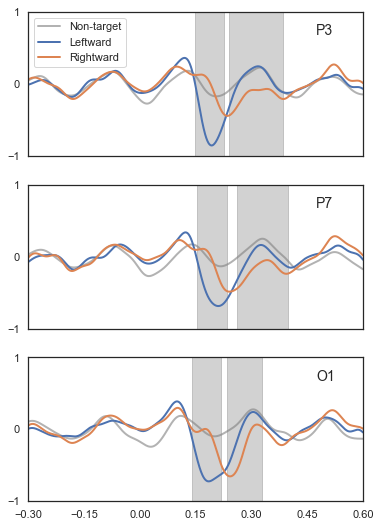

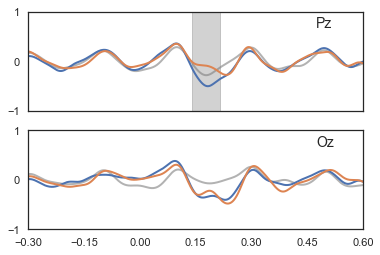

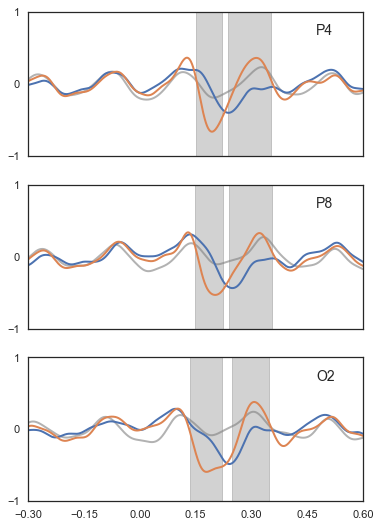

In [5]:
def fig1plot(t, y, epochs, clu, p_clu):
    cls_name=('non', 'left', 'right')
    ch_name= ['Pz', 'P3', 'P4', 'P7', 'P8', 'Oz', 'O1', 'O2']
    ch_order = [('P3', 'P7', 'O1'), ('P4', 'P8', 'O2'), ('Pz', 'Oz')]
    base = 0
    ylim = 1
    p_th = 0.001
    ch_fontsize=14
    legend_fontsize=11
    ticks_fontsize=11
    
    fig1, ax1 = plt.subplots(3, 1, figsize=(6, 9), sharex=True)
    fig2, ax2 = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
    fig3, ax3 = plt.subplots(3, 1, figsize=(6, 9), sharex=True)
    
    # hemispheres
    for j, axes in enumerate([ax1, ax3, ax2]):
        ch_ind = [ch_name.index(i) for i in ch_order[j]]
        for i, ax in enumerate(axes):
            ax.tick_params(axis='both', labelsize=ticks_fontsize, length=5, which='major')
            ax.set_xticks([-0.3, -0.15, 0, 0.15, 0.3, 0.45, 0.6])
            ax.set_yticks([-1, 0, 1])
            ax.set_ylim([-ylim, ylim])
            ax.set_xlim([t[0], t[-1]])
            # nontarget
            non_tar = epochs[y==0, ch_ind[i], :].mean(axis=0)
            line1, = ax.plot(t, non_tar, c='gray', alpha=0.6, label='non-target', linewidth=2)
            # leftward
            line2, = ax.plot(t, epochs[y == 1, ch_ind[i], :].mean(axis=0), label='left', linewidth=2)
            # rightward
            line3, = ax.plot(t, epochs[y == 2, ch_ind[i], :].mean(axis=0), label='right', linewidth=2)
            # shadow
#             h = None
            for i_c, c in enumerate(clu[ch_ind[i]]):
                c = c[0]
                if c.start < 300 or c.stop > 800:
                    continue
                if p_clu[ch_ind[i]][i_c] <= p_th:
                    h = ax.axvspan(t[base + c.start], t[base + (c.stop - 1)],
                                color=(0.3, 0.3, 0.3), alpha=0.25)
            ax.text(0.86, 0.84, ch_order[j][i], fontsize=ch_fontsize, transform=ax.transAxes)
            if (not j) and (not i):
                ax.legend((line1, line2, line3), ('Non-target', 'Leftward', 'Rightward'))
    return [fig1, fig2, fig3]

t = np.linspace(-0.3, 0.6, epochs.shape[-1])
figs = fig1plot(t, y, epochs, clu, p_clu)
plt.show()

## ERP Analysis

In [6]:
ch_names = ['Pz', 'P3', 'P4', 'P7', 'P8', 'Oz', 'O1', 'O2']
times = np.arange(t_ori[0], t_ori[1], 1/1000)

In [7]:
def hemi(ch):
    if ch in ['P3', 'P7', 'O1']:
        return 'lh'
    elif ch in ['P4', 'P8', 'O2']:
        return 'rh'
    else:
        return 'mid'


latency = []
for d in data_list:
    epochs = d['epochs']
    y = d['y']
    # left evoked
    l_ = epochs[y==1].mean(axis=0)
    # right evoked
    r_ = epochs[y==2].mean(axis=0)
    # compute latency
    for i, ch in enumerate(ch_names):
        h = hemi(ch)
        loc, t, val = _get_peak(l_[[i]], times, tmin=0.1, tmax=0.3, mode='neg')
        latency.append([ch, h, 'leftward', times[t], val])
        loc, t, val = _get_peak(r_[[i]], times, tmin=0.1, tmax=0.3, mode='neg')
        latency.append([ch, h, 'rightward', times[t], val])

In [8]:
lag_df = pd.DataFrame(latency, columns=['Channel', 'Hemisphere', 'Direction', 'Latency', 'Amplitude'])
lag_df.head(10)

,Channel,Hemisphere,Direction,Latency,Amplitude
0,Pz,mid,leftward,0.178,-0.616710
1,Pz,mid,rightward,0.257,0.105850
2,P3,lh,leftward,0.186,-0.601959
3,P3,lh,rightward,0.257,-0.386991
4,P4,rh,leftward,0.191,-0.149742
5,P4,rh,rightward,0.187,-0.397702
6,P7,lh,leftward,0.202,-0.430342
7,P7,lh,rightward,0.262,-0.221281
8,P8,rh,leftward,0.264,-0.065117
9,P8,rh,rightward,0.287,-0.034000


### Latency

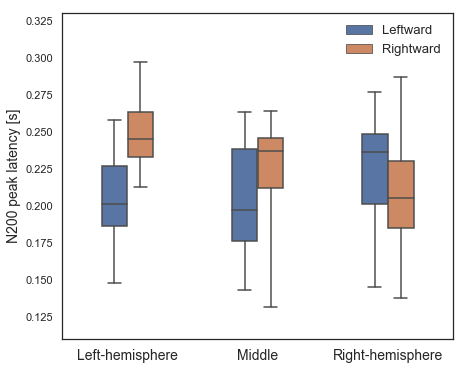

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(7, 6))
sns.boxplot(x='Hemisphere', 
            y='Latency', 
            hue='Direction',
            data=lag_df, 
            order=['lh', 'mid', 'rh'],
            width=0.4,
            whis=5, # no outlier points
            ax=axes)
handles, _ = axes.get_legend_handles_labels()
plt.ylim([0.11, 0.33])
plt.ylabel('N200 peak latency [s]', fontsize=14)
plt.xlabel(None)
plt.xticks(range(3), ['Left-hemisphere', 'Middle', 'Right-hemisphere'], fontsize=14)
plt.legend(handles, ['Leftward', 'Rightward'], frameon=False, fontsize=13)
plt.show()

In [10]:
# t-test leftward vs rightward on different hemispheres
# lh
l_ = lag_df[(lag_df.Hemisphere == 'lh') & (lag_df.Direction == 'leftward')]
r_ = lag_df[(lag_df.Hemisphere == 'lh') & (lag_df.Direction == 'rightward')]
print('lh: ', ttest_ind(l_.Latency.values, r_.Latency.values))
# rh
l_ = lag_df[(lag_df.Hemisphere == 'rh') & (lag_df.Direction == 'leftward')]
r_ = lag_df[(lag_df.Hemisphere == 'rh') & (lag_df.Direction == 'rightward')]
print('rh: ', ttest_ind(l_.Latency.values, r_.Latency.values))
# mid
l_ = lag_df[(lag_df.Hemisphere == 'mid') & (lag_df.Direction == 'leftward')]
r_ = lag_df[(lag_df.Hemisphere == 'mid') & (lag_df.Direction == 'rightward')]
print('mid: ', ttest_ind(l_.Latency.values, r_.Latency.values))

lh:  Ttest_indResult(statistic=-6.409696292518894, pvalue=2.851720994902006e-08)
rh:  Ttest_indResult(statistic=2.4857981276255305, pvalue=0.015829464730074603)
mid:  Ttest_indResult(statistic=-1.3033460215644939, pvalue=0.20029855160674384)


In [11]:
# t-test  lh vs rh for different stimuli
# leftward
l_lh = lag_df[(lag_df.Hemisphere == 'lh') & (lag_df.Direction == 'leftward')]
l_rh = lag_df[(lag_df.Hemisphere == 'rh') & (lag_df.Direction == 'leftward')]
print('leftward lh vs rh: ', ttest_ind(l_lh.Latency.values, l_rh.Latency.values,))
# rightward
r_lh = lag_df[(lag_df.Hemisphere == 'lh') & (lag_df.Direction == 'rightward')]
r_rh = lag_df[(lag_df.Hemisphere == 'rh') & (lag_df.Direction == 'rightward')]
print('rightward lh vs rh: ', ttest_ind(r_lh.Latency.values, r_rh.Latency.values,))

leftward lh vs rh:  Ttest_indResult(statistic=-2.832932037441749, pvalue=0.006333535214136014)
rightward lh vs rh:  Ttest_indResult(statistic=5.400832658324064, pvalue=1.292993358071489e-06)


### Amplitude

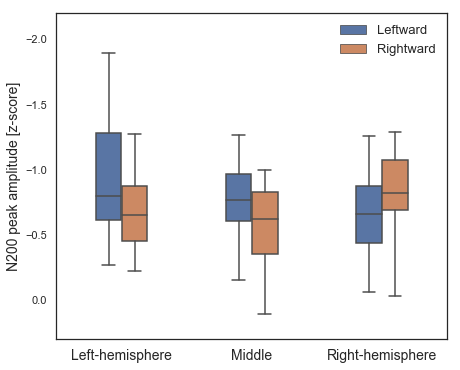

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(7, 6))
sns.boxplot(x='Hemisphere', 
            y='Amplitude', 
            hue='Direction',
            data=lag_df, 
            order=['lh', 'mid', 'rh'],
            width=0.4,
            whis=5, # no outlier points
            ax=axes)
handles, _ = axes.get_legend_handles_labels()
plt.ylim([-2.2, 0.3])
plt.gca().invert_yaxis()
plt.ylabel('N200 peak amplitude [z-score]', fontsize=14)
plt.xlabel(None)
plt.xticks(range(3), ['Left-hemisphere', 'Middle', 'Right-hemisphere'], fontsize=14)
plt.legend(handles, ['Leftward', 'Rightward'], frameon=False, fontsize=13)
plt.show()

In [13]:
# t-test leftward vs rightward on different hemispheres
# lh
l_ = lag_df[(lag_df.Hemisphere == 'lh') & (lag_df.Direction == 'leftward')]
r_ = lag_df[(lag_df.Hemisphere == 'lh') & (lag_df.Direction == 'rightward')]
print('lh: ', ttest_ind(l_.Amplitude.values, r_.Amplitude.values))
# rh
l_ = lag_df[(lag_df.Hemisphere == 'rh') & (lag_df.Direction == 'leftward')]
r_ = lag_df[(lag_df.Hemisphere == 'rh') & (lag_df.Direction == 'rightward')]
print('rh: ', ttest_ind(l_.Amplitude.values, r_.Amplitude.values))
# mid
l_ = lag_df[(lag_df.Hemisphere == 'mid') & (lag_df.Direction == 'leftward')]
r_ = lag_df[(lag_df.Hemisphere == 'mid') & (lag_df.Direction == 'rightward')]
print('mid: ', ttest_ind(l_.Amplitude.values, r_.Amplitude.values))

lh:  Ttest_indResult(statistic=-2.164937251616079, pvalue=0.03451994065525537)
rh:  Ttest_indResult(statistic=2.134365027565384, pvalue=0.03705120129798897)
mid:  Ttest_indResult(statistic=-1.9478601709738068, pvalue=0.05884698919753304)


In [14]:
# t-test  lh vs rh for different stimuli
# leftward
l_lh = lag_df[(lag_df.Hemisphere == 'lh') & (lag_df.Direction == 'leftward')]
l_rh = lag_df[(lag_df.Hemisphere == 'rh') & (lag_df.Direction == 'leftward')]
print('leftward lh vs rh: ', ttest_ind(l_lh.Amplitude.values, l_rh.Amplitude.values,))
# rightward
r_lh = lag_df[(lag_df.Hemisphere == 'lh') & (lag_df.Direction == 'rightward')]
r_rh = lag_df[(lag_df.Hemisphere == 'rh') & (lag_df.Direction == 'rightward')]
print('rightward lh vs rh: ', ttest_ind(r_lh.Amplitude.values, r_rh.Amplitude.values,))

leftward lh vs rh:  Ttest_indResult(statistic=-2.604612964673867, pvalue=0.011664541671651301)
rightward lh vs rh:  Ttest_indResult(statistic=1.6062656664654056, pvalue=0.11364685946852258)


## ROC Analysis

In [15]:
fpr_interp = np.linspace(0, 1, 200)

def evaluate_multiclass(y_pred, y_true):
    n_classes = len(np.unique(y_true))
    y_pred_label = np.argmax(y_pred, axis=1)
    # onehot label
    y_true_onehot = np.eye(n_classes)[y_true]
    roc = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred[:, i])
        f = interp1d(fpr, tpr)
        tpr = f(fpr_interp)
        roc.append(tpr)
    roc = np.array(roc)
    return roc

def cross_val(estimator, X, y, n=2):
    k_fold_rocs = []
    for train_ind, test_ind in utils.uniform_kfold(y):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        # normalize
        mean_ = X_train.mean(axis=(0, 2), keepdims=True)
        std_ = X_train.std(axis=(0, 2), keepdims=True)
        X_train -= mean_
        X_train /= std_
        X_test -= mean_
        X_test /= std_
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))
        estimator.fit(X_train, y_train)
        y_pred = utils.pred_ave(estimator, X_test, y_test, n=n)
        roc = evaluate_multiclass(y_pred, y_test)
        k_fold_rocs.append(roc)
    k_fold_rocs = np.array(k_fold_rocs).mean(axis=0)
    return k_fold_rocs
    

In [16]:
estimator = LogisticRegression(class_weight='balanced', solver='liblinear', multi_class='ovr')
roc_subjects_classes = []
for d in data_list:
    # cut epochs (0-0.5s)
    epochs = utils.timewindow(t_ori, t_tar, d['epochs'])
    # downsample and reshape to 2d matrix
    X = epochs[..., ::25]
    y = d['y']
    roc = cross_val(estimator, X, y)
    roc_subjects_classes.append(roc)
roc_subjects_classes = np.array(roc_subjects_classes)

Leftward AUC: 0.9197 ± 0.0498
Rightward AUC: 0.9318 ± 0.0448


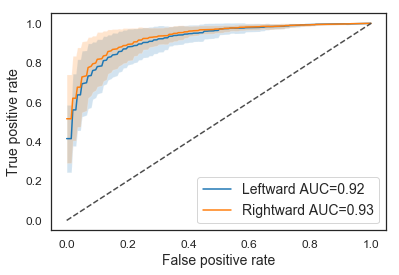

In [17]:
# mean rocs for each classes
rocs_classes = roc_subjects_classes.mean(axis=0)
roc_classes_err = roc_subjects_classes.std(axis=0)

cmap = plt.get_cmap('tab10')
cls_names=('Non-target', 'Leftward', 'Rightward')
c = ['gray', cmap(0), cmap(1)]
auc = np.trapz(rocs_classes, fpr_interp, axis=1)
lines = []
plt.figure()
for i in range(1, 3):
    line, = plt.plot(fpr_interp, rocs_classes[i], c=c[i])
    lines.append(line)
    plt.fill_between(fpr_interp, rocs_classes[i]-roc_classes_err[i], rocs_classes[i]+roc_classes_err[i], alpha=0.2, facecolor=c[i])
    print('%s AUC: %.4f ± %.4f' % (cls_names[i], auc[i], np.std(np.trapz(roc_subjects_classes[:, i], fpr_interp, axis=-1))))
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.legend(lines, ['%s AUC=%.2f' % (cls_names[i], auc[i]) for i in range(1, 3)], fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.gca().tick_params(axis='both', which='major', labelsize='large')
plt.show()

In [18]:
roc_subjects_n_trials = []
n_trials = [1, 2, 3, 5, 10]
for i in n_trials:
    roc_subjects = []
    for d in data_list:
        # cut epochs (0-0.5s)
        epochs = utils.timewindow(t_ori, t_tar, d['epochs'])
        # downsample and reshape to 2d matrix
        X = epochs[..., ::25]
        y = d['y']
        roc = cross_val(estimator, X, y, n=i)
        roc_subjects.append(roc)  # roc for different classes
    roc_subjects_n_trials.append(np.mean(roc_subjects, axis=0))
roc_subjects_n_trials = np.array(roc_subjects_n_trials)
print(roc_subjects_n_trials.shape)

(5, 3, 200)


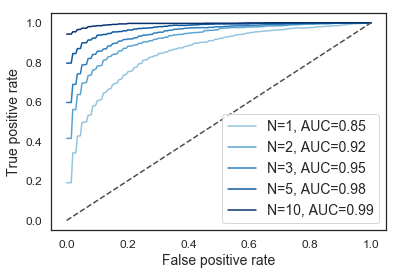

In [19]:
# auc for leftward
roc_subjects_n_trials_left = roc_subjects_n_trials[:, 1].copy()
auc_n_trials = np.sum(roc_subjects_n_trials_left, axis=-1) / len(fpr_interp)
plt.figure()

gray_map = plt.get_cmap('Blues')
for i in range(len(n_trials)):
    plt.plot(fpr_interp, roc_subjects_n_trials_left[i], c=gray_map(0.15 * i + 0.4),
             label='N=%d, AUC=%.2f' % (n_trials[i], auc_n_trials[i]))
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.legend(fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.gca().tick_params(axis='both', which='major', labelsize='large')
plt.show()

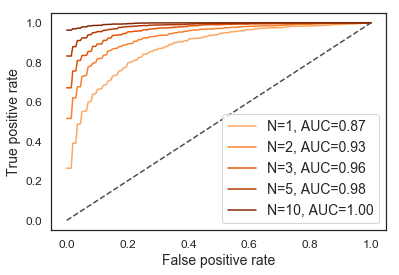

In [20]:
# auc for rightward
roc_subjects_n_trials_right = roc_subjects_n_trials[:, 2].copy()
auc_n_trials = np.sum(roc_subjects_n_trials_right, axis=-1) / len(fpr_interp)
plt.figure()

gray_map = plt.get_cmap('Oranges')
for i in range(len(n_trials)):
    plt.plot(fpr_interp, roc_subjects_n_trials_right[i], c=gray_map(0.15 * i + 0.4),
             label='N=%d, AUC=%.2f' % (n_trials[i], auc_n_trials[i]))
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.legend(fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.gca().tick_params(axis='both', which='major', labelsize='large')
plt.show()

## Online error rate

In [21]:
def cross_val_y_pred(estimator, X, y):
    y_pred_n_fold = []
    y_true_n_fold = []
    for train_ind, test_ind in utils.uniform_kfold(y):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        # normalize
        mean_ = X_train.mean(axis=(0, 2), keepdims=True)
        std_ = X_train.std(axis=(0, 2), keepdims=True)
        X_train -= mean_
        X_train /= std_
        X_test -= mean_
        X_test /= std_
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))
        estimator.fit(X_train, y_train)
        y_pred = utils.pred_ave(estimator, X_test, y_test, n=1)
        y_pred_n_fold.append(y_pred)
        y_true_n_fold.append(y_test)
    y_pred_n_fold = np.concatenate(y_pred_n_fold, axis=0)
    y_true_n_fold = np.concatenate(y_true_n_fold, axis=0)
    return y_pred_n_fold, y_true_n_fold

def train_estimate_online_correct_rate(data):
    # cut epochs (0-0.5s)
    epochs = utils.timewindow(t_ori, t_tar, data['epochs'])
    # downsample and reshape to 2d matrix
    X = epochs[..., ::25]
    y = data['y']
    y_pred, y_true = cross_val_y_pred(estimator, X, y)
    pc = utils.estimate_accu_dual(y_true, y_pred, n_avg=5)
    return pc

In [22]:
def find_n_trials(pc, expected_accu):
    x = np.linspace(1, 5, 100)
    interp_f = interp1d(np.arange(1,6), pc)
    interp_pc = interp_f(x)
    n_trials = x[np.argmin(np.abs(interp_pc - expected_accu))]
    return n_trials

In [23]:
estimator = LogisticRegression(class_weight='balanced', solver='liblinear', multi_class='ovr')
# error rate estimation
y_pred_n_fold = []
s1_data = data_list[f_list.index(os.path.join(data_dir, 'S1_epochs.npz'))]
s6_data = data_list[f_list.index(os.path.join(data_dir, 'S6_epochs.npz'))]
s10_data = data_list[f_list.index(os.path.join(data_dir, 'S10_epochs.npz'))]

pc_s1 = train_estimate_online_correct_rate(s1_data)
pc_s6 = train_estimate_online_correct_rate(s6_data)
pc_s10 = train_estimate_online_correct_rate(s10_data)


In [24]:
expected_accu = 0.85
s1_n_trial = find_n_trials(pc_s1, expected_accu)
s6_n_trial = find_n_trials(pc_s6, expected_accu)
s10_n_trial = find_n_trials(pc_s10, expected_accu)
print(s1_n_trial, s6_n_trial, s10_n_trial)

1.8080808080808082 3.2222222222222223 5.0


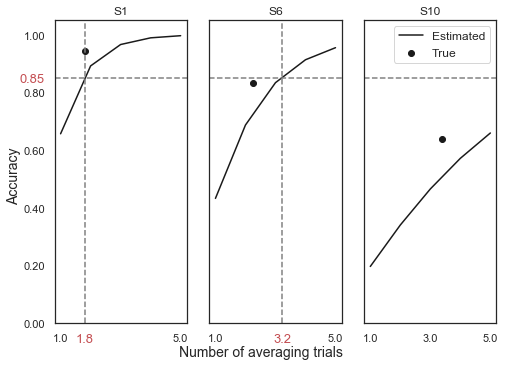

In [25]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(7, 5))
axes[0].plot(np.arange(1,6), pc_s1, c='k')
axes[0].scatter(1.83, 0.944, c='k')
axes[0].axhline(y=expected_accu, c='gray', linestyle='dashed')
axes[0].axvline(x=s1_n_trial, c='gray', linestyle='dashed')
axes[0].set_ylim([0, 1.05])
axes[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 0.85, 1])
y_expected_tick = axes[0].get_yticklabels()[5]
y_expected_tick.set_color('r')
y_expected_tick.set_fontsize(13)
x = [1,s1_n_trial, 5]
axes[0].set_xticks(x)
axes[0].set_xticklabels(['%.1f' % i for i in x])
x_n_trial_tick = axes[0].get_xticklabels()[1]
x_n_trial_tick.set_color('r')
x_n_trial_tick.set_fontsize(13)
axes[0].set_title('S1')

axes[1].plot(np.arange(1,6), pc_s6, c='k')
axes[1].scatter(2.25, 0.833, c='k')
axes[1].axhline(y=expected_accu, c='gray', linestyle='dashed')
axes[1].axvline(x=s6_n_trial, c='gray', linestyle='dashed')
x = [1, s6_n_trial, 5]
axes[1].set_xticks(x)
axes[1].set_xticklabels(['%.1f' % i for i in x])
x_n_trial_tick = axes[1].get_xticklabels()[1]
x_n_trial_tick.set_color('r')
x_n_trial_tick.set_fontsize(13)
axes[1].set_title('S6')

axes[2].plot(np.arange(1,6), pc_s10, c='k', label='Estimated')
axes[2].scatter(3.4, 0.639, c='k', label='True')
axes[2].axhline(y=expected_accu, c='gray', linestyle='dashed')
x = [1,3,5]
axes[2].set_xticks(x)
axes[2].set_xticklabels(['%.1f' % i for i in x])
axes[2].set_title('S10')
axes[2].legend(fontsize=12)

fig.text(0.5, 0.01, 'Number of averaging trials', ha='center', va='center', fontsize=14)
fig.text(0.01, 0.5, 'Accuracy', ha='center', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
plt.show()